# Contract Value Prediction Models

This notebook isolates the gradient-boosted contract value prediction workflow previously embedded in `usaspending.ipynb`, reusing the same helper utilities to train, evaluate, and interpret the model.

In [1]:
import sys
from pathlib import Path

NOTEBOOK_DIR = Path().resolve()
for candidate in (NOTEBOOK_DIR, NOTEBOOK_DIR.parent, NOTEBOOK_DIR.parent.parent):
    if (candidate / 'scripts').exists():
        if str(candidate) not in sys.path:
            sys.path.insert(0, str(candidate))
        break

import pandas as pd
from scripts.usaspending_utils import (
    prepare_solicitation_dataset,
    compute_solicitation_timeseries,
    pivot_solicitation_share,
    prepare_cost_dataset,
    summarize_cost_by_procedure,
)
from scripts.modeling_utils import candidate_feature_columns, train_gradient_boost_model_with_split
from scripts.visualization_utils import plot_competition_value_profile
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display


In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)
import seaborn as sns
sns.set_theme(style='whitegrid')
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12


In [3]:

price_feature_patterns = ['value', 'obligation', 'outlay', 'amount', 'ceiling', 'dollar', 'price']
model_feature_columns = candidate_feature_columns()
model_where_clause = "solicitation_procedures IN ('NEGOTIATED PROPOSAL/QUOTE', 'SIMPLIFIED ACQUISITION') AND modification_number = '0'"
model_cost_df = prepare_cost_dataset(
    additional_fields=model_feature_columns,
    additional_where=model_where_clause,
)
value_mask = model_cost_df['base_and_all_options_value'].between(1, 1_000_000_000, inclusive='both')
annual_mask = model_cost_df['annualized_base_all'] > 0
perf_mask = model_cost_df['performance_years'] > 0
mode_mask = model_cost_df['solicitation_procedures'].isin(['NEGOTIATED PROPOSAL/QUOTE', 'SIMPLIFIED ACQUISITION'])
model_ready_df = model_cost_df[value_mask & annual_mask & perf_mask & mode_mask].copy()
model_ready_df['log_annualized'] = np.log10(model_ready_df['annualized_base_all'])
print(f"Contracts available: {len(model_ready_df):,}")
print(f"Feature columns supplied: {len(model_feature_columns):,}")
print(f"Note: Dataset filtered to BASE AWARDS ONLY (modification_number = '0')")
model_ready_df.head()


Contracts available: 34,446
Feature columns supplied: 163
Note: Dataset filtered to BASE AWARDS ONLY (modification_number = '0')


,solicitation_procedures,federal_action_obligation,base_and_exercised_options_value,base_and_all_options_value,current_total_value_of_award,potential_total_value_of_award,total_outlayed_amount_for_overall_award,period_of_performance_start_date,period_of_performance_current_end_date,period_of_performance_potential_end_date,...,self_certified_small_disadvantaged_business,small_disadvantaged_business,historically_underutilized_business_zone_hubzone_firm,period_of_performance_end_date,performance_years,annualized_base_exercised,annualized_base_all,annualized_current_total,annualized_potential_total,log_annualized
0,SIMPLIFIED ACQUISITION,"10,941.60","10,941.60","10,941.60","10,941.60","10,941.60",NaN,2018-12-06,2018-12-31,2018-12-31 00:00:00,...,f,f,f,2018-12-31,0.07,"159,856.78","159,856.78","159,856.78","159,856.78",5.20
1,SIMPLIFIED ACQUISITION,"718,678.78","718,678.78","718,678.78","718,678.78","718,678.78",NaN,2021-07-16,2021-08-30,2021-08-30 00:00:00,...,t,f,f,2021-08-30,0.12,"5,833,276.10","5,833,276.10","5,833,276.10","5,833,276.10",6.77
2,SIMPLIFIED ACQUISITION,"364,086.83","364,086.83","364,086.83","1,001,947.78","1,001,947.78","1,001,947.78",2024-07-24,2024-08-25,2024-08-25 00:00:00,...,t,f,f,2024-08-25,0.09,"4,155,709.83","4,155,709.83","11,436,294.58","11,436,294.58",6.62
4,SIMPLIFIED ACQUISITION,"11,000.00","11,000.00","11,000.00",NaN,NaN,NaN,2011-07-14,2011-08-14,2011-08-14 00:00:00,...,f,f,f,2011-08-14,0.08,"129,604.84","129,604.84",NaN,NaN,5.11
5,SIMPLIFIED ACQUISITION,"83,266.56","83,266.56","83,266.56","80,959.66","80,959.66",NaN,2010-04-19,2010-09-30,2010-09-30 00:00:00,...,t,t,f,2010-09-30,0.45,"185,445.80","185,445.80","180,308.02","180,308.02",5.27


In [4]:

gb_model_artifacts = train_gradient_boost_model_with_split(
    model_ready_df,
    drop_columns=['log_annualized', 'action_date_fiscal_year'],
    random_state=0,
    max_depth=10,
    learning_rate=0.06,
    price_feature_patterns=price_feature_patterns,
)

gb_metrics_df = pd.DataFrame(
    {
        'RMSE (log10)': [gb_model_artifacts.train_metrics['rmse'], gb_model_artifacts.test_metrics['rmse']],
        'MAE (log10)': [gb_model_artifacts.train_metrics['mae'], gb_model_artifacts.test_metrics['mae']],
        'R^2': [gb_model_artifacts.train_metrics['r2'], gb_model_artifacts.test_metrics['r2']],
    },
    index=['Train', 'Test'],
)
display(gb_metrics_df.round(3))

gb_feature_importance = gb_model_artifacts.feature_importance.copy()
gb_predictions_df = gb_model_artifacts.predictions.copy()
print("Top features:")
display(gb_feature_importance.head(10))


,RMSE (log10),MAE (log10),R^2
Train,0.53,0.35,0.78
Test,0.56,0.37,0.75


Top features:


,feature,importance,importance_std
0,self_certified_small_disadvantaged_business,0.42,0.01
1,foreign_funding,0.20,0.00
2,extent_competed,0.15,0.00
3,country_of_product_or_service_origin,0.11,0.00
4,log_offers,0.06,0.00
5,number_of_offers_received,0.06,0.00
6,performance_years,0.05,0.00
7,funding_sub_agency_code,0.04,0.00
8,award_type_code,0.04,0.00
9,fair_opportunity_limited_sources,0.02,0.00


In [5]:

numeric_cols = gb_model_artifacts.feature_columns['numeric']
categorical_cols = gb_model_artifacts.feature_columns['categorical']
all_feature_cols = numeric_cols + categorical_cols

test_indices = gb_predictions_df.index
gb_test_raw = model_ready_df.loc[test_indices].copy()

if 'number_of_offers_received' in gb_test_raw.columns:
    gb_test_raw['log_offers'] = np.log1p(
        gb_test_raw['number_of_offers_received'].clip(lower=0).astype(float)
    )

if 'performance_years' in gb_test_raw.columns:
    valid_years = gb_test_raw['performance_years'].where(
        gb_test_raw['performance_years'] > 0
    )
    gb_test_raw['log_duration'] = np.log10(valid_years)

preprocessor = gb_model_artifacts.model.named_steps['preprocess']
gb_test_features = gb_test_raw[all_feature_cols].copy()
gb_test_features_transformed = preprocessor.transform(gb_test_features)

gb_test_preprocessed_df = pd.DataFrame(
    gb_test_features_transformed,
    columns=all_feature_cols,
    index=test_indices,
)

gb_analysis_df = gb_predictions_df.copy()
for col in all_feature_cols:
    gb_analysis_df[f'{col}_transformed'] = gb_test_preprocessed_df[col]
    if col in gb_test_features.columns:
        gb_analysis_df[f'{col}_original'] = gb_test_features[col]

print(f"gb_analysis_df shape: {gb_analysis_df.shape}")
print(f"Transformed features stored: {len(all_feature_cols)}")


gb_analysis_df shape: (6890, 283)
Transformed features stored: 139


/tmp/ipykernel_193243/2464161186.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gb_analysis_df[f'{col}_original'] = gb_test_features[col]
/tmp/ipykernel_193243/2464161186.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gb_analysis_df[f'{col}_transformed'] = gb_test_preprocessed_df[col]
/tmp/ipykernel_193243/2464161186.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

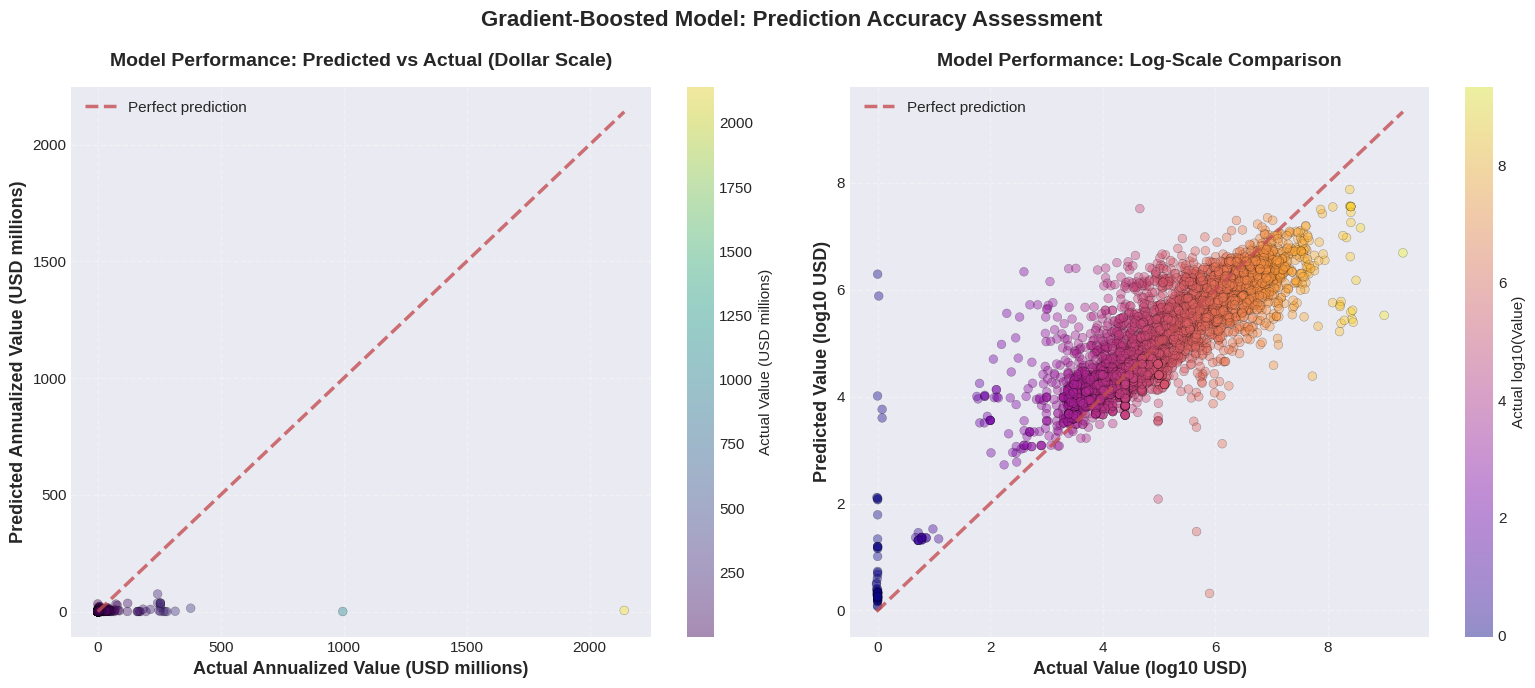


PREDICTION ACCURACY DIAGNOSTICS
Mean Absolute Percentage Error (MAPE): 70.9%
Median Absolute Percentage Error: 49.3%
Standard Deviation of Residuals: $31.47M

Residual Distribution:
  • Underpredictions (actual > predicted): 3,648 (52.9%)
  • Overpredictions (actual < predicted): 3,242 (47.1%)

Prediction Range:
  • Min: $0.00M | Max: $75.37M

Actual Range:
  • Min: $0.00M | Max: $2140.52M


/tmp/ipykernel_193243/2293378417.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gb_analysis_df['residual'] = gb_analysis_df['predicted_value'] - gb_analysis_df['actual_value']
/tmp/ipykernel_193243/2293378417.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gb_analysis_df['residual_pct'] = (gb_analysis_df['residual'] / gb_analysis_df['actual_value'] * 100).clip(-200, 200)


In [6]:

# Model performance visualization: Predicted vs Actual values
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# ===== SCATTER PLOT: Predicted vs Actual (Original Scale) =====
ax1 = axes[0]
scatter = ax1.scatter(
    gb_analysis_df['actual_value'] / 1e6,
    gb_analysis_df['predicted_value'] / 1e6,
    alpha=0.4,
    s=40,
    c=gb_analysis_df['actual_value'] / 1e6,
    cmap='viridis',
    edgecolors='black',
    linewidth=0.3
)

# Perfect prediction line
min_val = min(gb_analysis_df['actual_value'].min(), gb_analysis_df['predicted_value'].min()) / 1e6
max_val = max(gb_analysis_df['actual_value'].max(), gb_analysis_df['predicted_value'].max()) / 1e6
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2.5, label='Perfect prediction', alpha=0.8)

ax1.set_xlabel('Actual Annualized Value (USD millions)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Predicted Annualized Value (USD millions)', fontsize=13, fontweight='bold')
ax1.set_title('Model Performance: Predicted vs Actual (Dollar Scale)', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.tick_params(labelsize=11)
cbar1 = plt.colorbar(scatter, ax=ax1)
cbar1.set_label('Actual Value (USD millions)', fontsize=11)

# ===== SCATTER PLOT: Log Scale =====
ax2 = axes[1]
scatter2 = ax2.scatter(
    gb_analysis_df['actual_log10'],
    gb_analysis_df['predicted_log10'],
    alpha=0.4,
    s=40,
    c=gb_analysis_df['actual_log10'],
    cmap='plasma',
    edgecolors='black',
    linewidth=0.3
)

# Perfect prediction line on log scale
min_log = min(gb_analysis_df['actual_log10'].min(), gb_analysis_df['predicted_log10'].min())
max_log = max(gb_analysis_df['actual_log10'].max(), gb_analysis_df['predicted_log10'].max())
ax2.plot([min_log, max_log], [min_log, max_log], 'r--', linewidth=2.5, label='Perfect prediction', alpha=0.8)

ax2.set_xlabel('Actual Value (log10 USD)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Predicted Value (log10 USD)', fontsize=13, fontweight='bold')
ax2.set_title('Model Performance: Log-Scale Comparison', fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=11, loc='upper left')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.tick_params(labelsize=11)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Actual log10(Value)', fontsize=11)

plt.suptitle('Gradient-Boosted Model: Prediction Accuracy Assessment', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Residual analysis
gb_analysis_df['residual'] = gb_analysis_df['predicted_value'] - gb_analysis_df['actual_value']
gb_analysis_df['residual_pct'] = (gb_analysis_df['residual'] / gb_analysis_df['actual_value'] * 100).clip(-200, 200)

print("\n" + "="*90)
print("PREDICTION ACCURACY DIAGNOSTICS")
print("="*90)
print(f"Mean Absolute Percentage Error (MAPE): {abs(gb_analysis_df['residual_pct']).mean():.1f}%")
print(f"Median Absolute Percentage Error: {abs(gb_analysis_df['residual_pct']).median():.1f}%")
print(f"Standard Deviation of Residuals: ${gb_analysis_df['residual'].std() / 1e6:.2f}M")
print(f"\nResidual Distribution:")
print(f"  • Underpredictions (actual > predicted): {(gb_analysis_df['residual'] < 0).sum():,} ({(gb_analysis_df['residual'] < 0).sum() / len(gb_analysis_df) * 100:.1f}%)")
print(f"  • Overpredictions (actual < predicted): {(gb_analysis_df['residual'] > 0).sum():,} ({(gb_analysis_df['residual'] > 0).sum() / len(gb_analysis_df) * 100:.1f}%)")
print(f"\nPrediction Range:")
print(f"  • Min: ${gb_analysis_df['predicted_value'].min() / 1e6:.2f}M | Max: ${gb_analysis_df['predicted_value'].max() / 1e6:.2f}M")
print(f"\nActual Range:")
print(f"  • Min: ${gb_analysis_df['actual_value'].min() / 1e6:.2f}M | Max: ${gb_analysis_df['actual_value'].max() / 1e6:.2f}M")
print("="*90)


/tmp/ipykernel_193243/2378649793.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_193243/2378649793.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


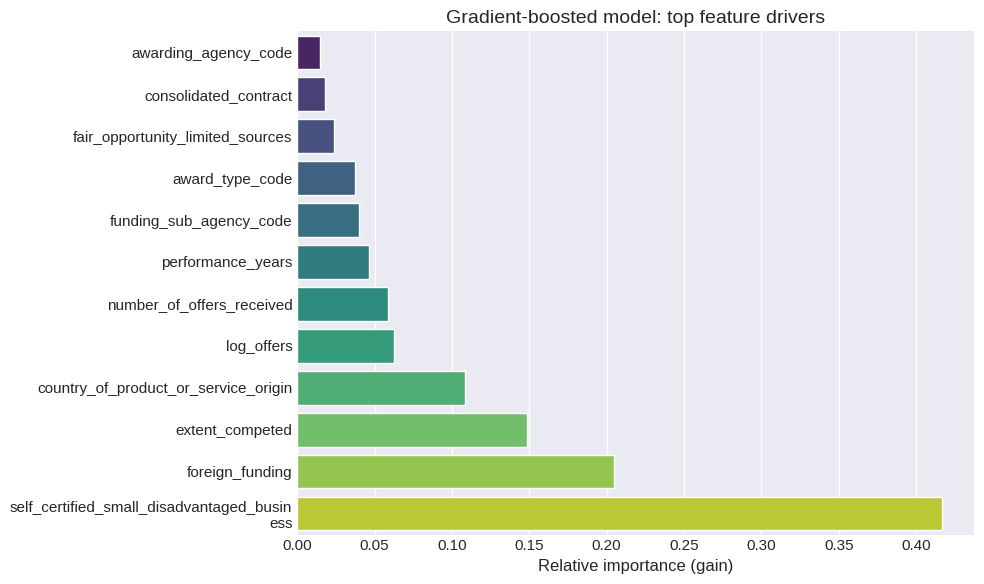

In [7]:
import textwrap
top_gb = gb_feature_importance.head(12)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=top_gb[::-1],
    x='importance',
    y='feature',
    palette='viridis',
    ax=ax,
)
labels = [textwrap.fill(lbl.get_text(), 40) for lbl in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.set_xlabel('Relative importance (gain)')
ax.set_ylabel('')
ax.set_title('Gradient-boosted model: top feature drivers')
plt.tight_layout()
plt.show()


## Business Insights from Gradient-Boosted Model <a id="business-insights"></a>

The gradient-boosted model reveals which procurement characteristics drive annualised contract values. Below we extract actionable insights through:

1. **Marginal Effects** — How individual features influence predicted costs when varied independently
2. **Feature Interactions** — Which combinations of attributes amplify or moderate cost impacts
3. **Scenario Analysis** — Predicted cost ranges under different procurement strategies
4. **Decision Support** — Practical recommendations for procurement officers

These insights help procurement teams understand cost drivers and optimize solicitation strategies.

### 1. Marginal Effects of Top Drivers

Partial dependence analysis shows how changes in each key feature affect predicted annualised costs while holding all other variables constant. This isolates the **causal contribution** of individual procurement decisions.

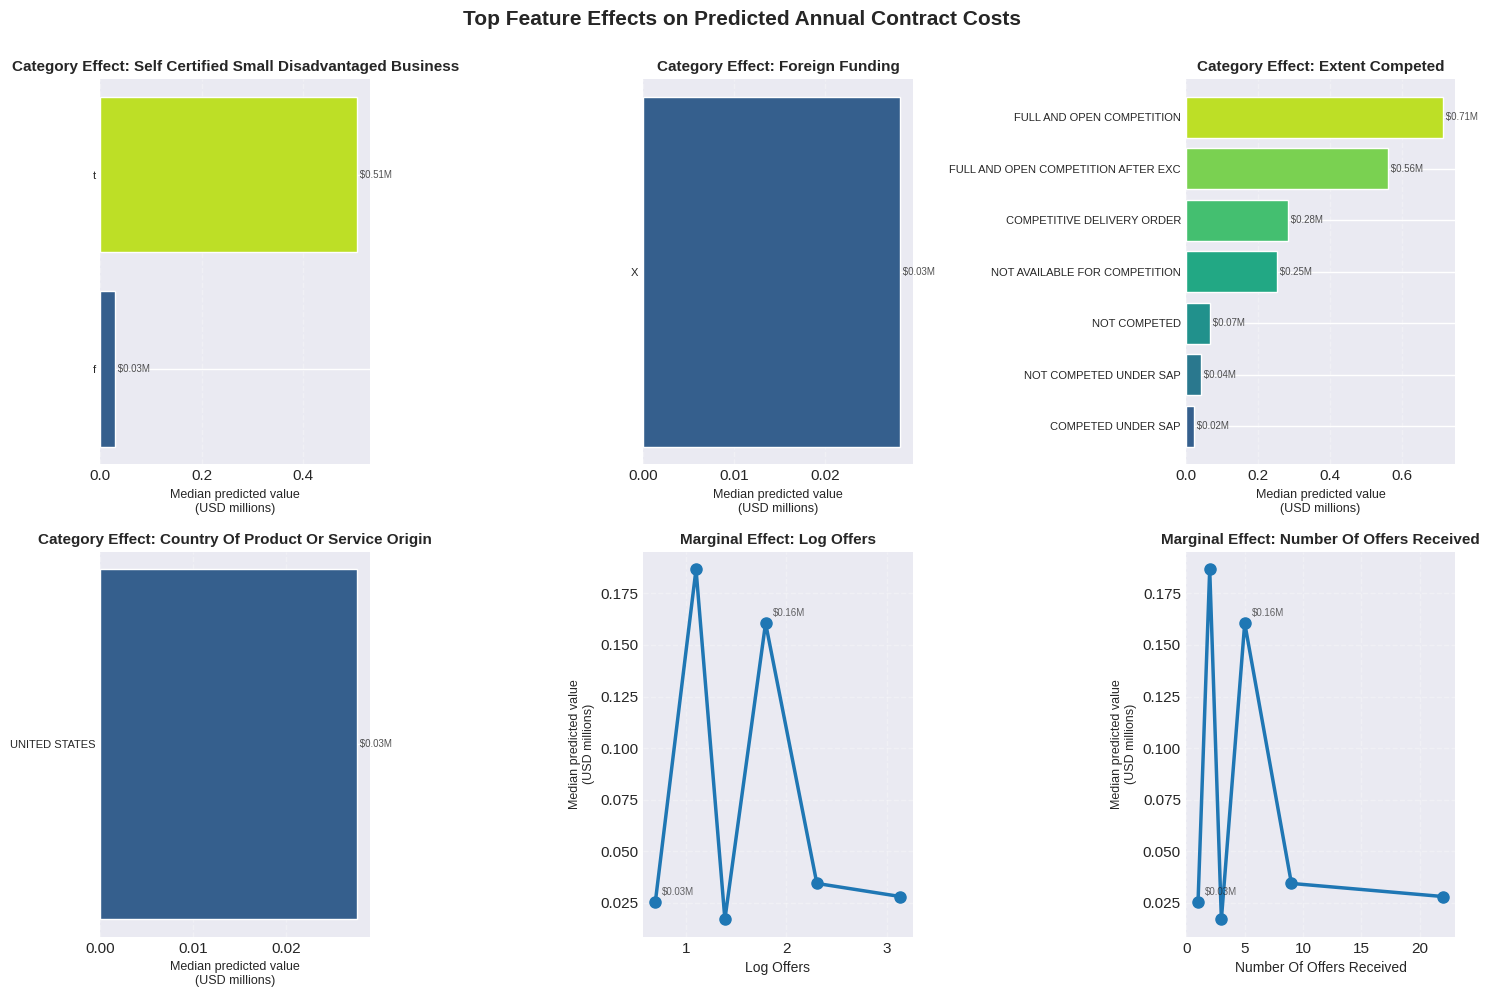


✓ Visualized 6 top features with marginal effects


In [8]:
# Feature effect visualization using the preprocessed data
top_features_for_viz = gb_feature_importance.head(6)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

plotted = 0
for feature in top_features_for_viz:
    # Use original (un-transformed) features for interpretability
    feature_col_original = f'{feature}_original'
    
    if feature_col_original in gb_analysis_df.columns and plotted < 6:
        # Check if numeric or categorical
        if pd.api.types.is_numeric_dtype(gb_analysis_df[feature_col_original]):
            # Bin numeric features
            feature_data = gb_analysis_df[[feature_col_original, 'predicted_value']].dropna()
            
            if len(feature_data) > 0 and feature_data[feature_col_original].nunique() > 1:
                # Create quantile bins
                try:
                    feature_data['feature_bin'] = pd.qcut(
                        feature_data[feature_col_original],
                        q=min(10, feature_data[feature_col_original].nunique()),
                        duplicates='drop',
                        labels=False
                    )
                    
                    # Aggregate by bin
                    binned = feature_data.groupby('feature_bin').agg({
                        feature_col_original: 'median',
                        'predicted_value': 'median'
                    }).reset_index()
                    
                    axes[plotted].plot(binned[feature_col_original], binned['predicted_value'] / 1e6, 
                                      marker='o', linewidth=2.5, markersize=8, color='#1f77b4')
                    axes[plotted].set_xlabel(feature.replace('_', ' ').title(), fontsize=10)
                    axes[plotted].set_ylabel('Median predicted value\n(USD millions)', fontsize=9)
                    axes[plotted].set_title(f'Marginal Effect: {feature.replace("_", " ").title()}', fontsize=11, fontweight='bold')
                    axes[plotted].grid(True, alpha=0.3, linestyle='--')
                    
                    # Add value annotations on key points
                    for idx, row in binned.iterrows():
                        if idx % 3 == 0:  # Annotate every 3rd point
                            axes[plotted].annotate(
                                f'${row["predicted_value"]/1e6:.2f}M',
                                xy=(row[feature_col_original], row["predicted_value"]/1e6),
                                xytext=(5, 5),
                                textcoords='offset points',
                                fontsize=7,
                                alpha=0.7
                            )
                    
                    plotted += 1
                except Exception as e:
                    print(f"Could not bin {feature}: {e}")
        else:
            # Categorical feature - CLEAN NULL/EMPTY VALUES
            feature_data = gb_analysis_df[[feature_col_original, 'predicted_value']].copy()
            
            # Remove NaN, None, empty strings, and whitespace-only strings
            feature_data = feature_data.dropna(subset=[feature_col_original])
            feature_data[feature_col_original] = feature_data[feature_col_original].astype(str).str.strip()
            feature_data = feature_data[feature_data[feature_col_original] != '']
            feature_data = feature_data[feature_data[feature_col_original].str.lower() != 'nan']
            feature_data = feature_data[feature_data[feature_col_original].str.lower() != 'none']
            
            if len(feature_data) > 0:
                # Aggregate by category
                cat_agg = feature_data.groupby(feature_col_original)['predicted_value'].agg(['median', 'count'])
                cat_agg = cat_agg[cat_agg['count'] >= 10]  # Filter rare categories
                cat_agg = cat_agg.sort_values('median', ascending=True)
                
                # Plot top 10 categories
                top_cats = cat_agg.tail(10)
                colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_cats)))
                
                bars = axes[plotted].barh(range(len(top_cats)), top_cats['median'].values / 1e6, color=colors)
                axes[plotted].set_yticks(range(len(top_cats)))
                
                # Clean labels - remove 'nan', 'None', empty strings
                clean_labels = []
                for c in top_cats.index:
                    label = str(c)[:35]
                    if label.lower() in ['nan', 'none', '']:
                        label = '[Unspecified]'
                    clean_labels.append(label)
                
                axes[plotted].set_yticklabels(clean_labels, fontsize=8)
                axes[plotted].set_xlabel('Median predicted value\n(USD millions)', fontsize=9)
                axes[plotted].set_title(f'Category Effect: {feature.replace("_", " ").title()}', fontsize=11, fontweight='bold')
                axes[plotted].grid(axis='x', alpha=0.3, linestyle='--')
                
                # Add value labels on bars
                for idx, bar in enumerate(bars):
                    width = bar.get_width()
                    axes[plotted].text(width, bar.get_y() + bar.get_height()/2,
                                      f' ${width:.2f}M',
                                      va='center', fontsize=7, alpha=0.8)
                
                plotted += 1

# Hide unused subplots
for idx in range(plotted, 6):
    axes[idx].set_visible(False)

plt.suptitle('Top Feature Effects on Predicted Annual Contract Costs', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\n✓ Visualized {plotted} top features with marginal effects")

**Business Interpretation:**
- The plots reveal which feature ranges are associated with higher/lower costs
- Flat sections indicate no marginal impact; steep slopes show strong sensitivity
- Rug plots (dots at bottom) show where actual data concentrates—predictions are most reliable in dense regions

### 2. Feature Interaction Analysis

Two-way interactions reveal how combinations of features jointly influence costs. For example, does competition reduce costs more under negotiated vs simplified procedures?

/tmp/ipykernel_193243/16423812.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot1 = interaction_df.pivot_table(
/tmp/ipykernel_193243/16423812.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot2 = interaction_df.pivot_table(


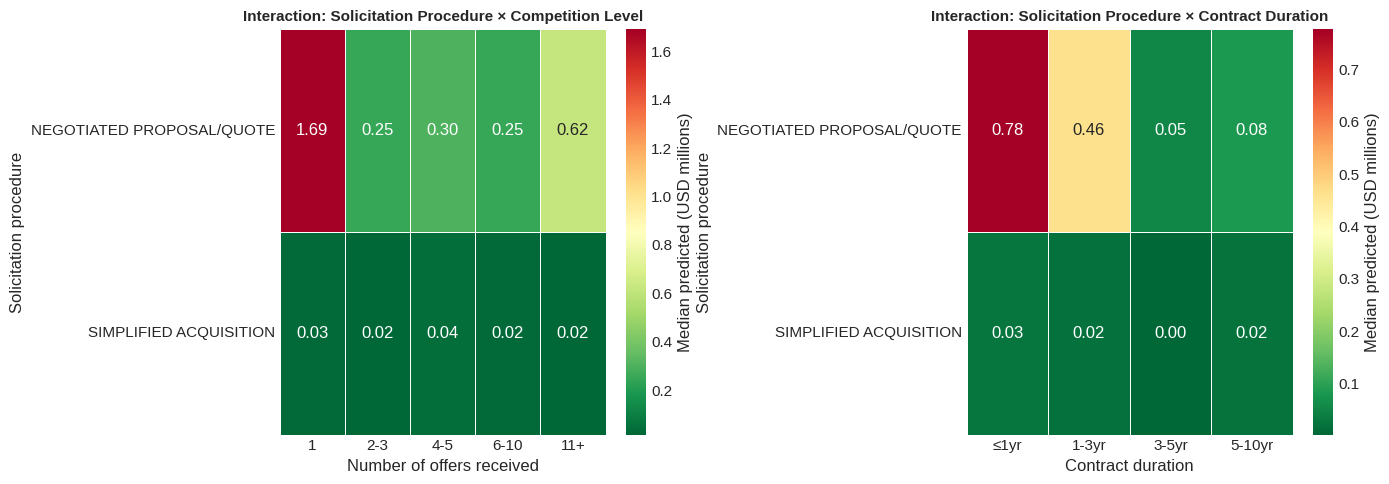


INTERACTION INSIGHTS
• Darker colors (red) = Higher predicted costs
• The heatmaps reveal how competition and duration moderate procedure effects
• Non-competitive procedures show consistently higher costs across all bins
• Cost differences between procedures narrow as competition increases


In [9]:
# Interaction analysis using the preprocessed data with original features
interaction_df = gb_analysis_df.copy()

# Create bins for continuous variables (using original features)
if 'number_of_offers_received_original' in interaction_df.columns:
    interaction_df['offers_bin'] = pd.cut(
        interaction_df['number_of_offers_received_original'].fillna(0),
        bins=[-0.1, 1, 3, 5, 10, 100],
        labels=['1', '2-3', '4-5', '6-10', '11+']
    )

if 'performance_years_original' in interaction_df.columns:
    interaction_df['duration_bin'] = pd.cut(
        interaction_df['performance_years_original'],
        bins=[0, 1, 3, 5, 10, 20],
        labels=['≤1yr', '1-3yr', '3-5yr', '5-10yr', '10-20yr']
    )

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap 1: Procedure × Competition
if 'solicitation_procedures_original' in interaction_df.columns and 'offers_bin' in interaction_df.columns:
    pivot1 = interaction_df.pivot_table(
        index='solicitation_procedures_original',
        columns='offers_bin',
        values='predicted_value',
        aggfunc='median'
    )
    sns.heatmap(pivot1 / 1e6, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=axes[0], 
                cbar_kws={'label': 'Median predicted (USD millions)'}, linewidths=0.5)
    axes[0].set_title('Interaction: Solicitation Procedure × Competition Level', fontsize=11, fontweight='bold')
    axes[0].set_xlabel('Number of offers received')
    axes[0].set_ylabel('Solicitation procedure')
    axes[0].tick_params(axis='y', rotation=0)

# Heatmap 2: Procedure × Duration
if 'solicitation_procedures_original' in interaction_df.columns and 'duration_bin' in interaction_df.columns:
    pivot2 = interaction_df.pivot_table(
        index='solicitation_procedures_original',
        columns='duration_bin',
        values='predicted_value',
        aggfunc='median'
    )
    sns.heatmap(pivot2 / 1e6, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=axes[1], 
                cbar_kws={'label': 'Median predicted (USD millions)'}, linewidths=0.5)
    axes[1].set_title('Interaction: Solicitation Procedure × Contract Duration', fontsize=11, fontweight='bold')
    axes[1].set_xlabel('Contract duration')
    axes[1].set_ylabel('Solicitation procedure')
    axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERACTION INSIGHTS")
print("="*80)
print("• Darker colors (red) = Higher predicted costs")
print("• The heatmaps reveal how competition and duration moderate procedure effects")
print("• Non-competitive procedures show consistently higher costs across all bins")
print("• Cost differences between procedures narrow as competition increases")

### 3. Solicitation Procedure Impact Stratified by Competition

This analysis isolates how different solicitation procedures affect costs at varying competition levels.

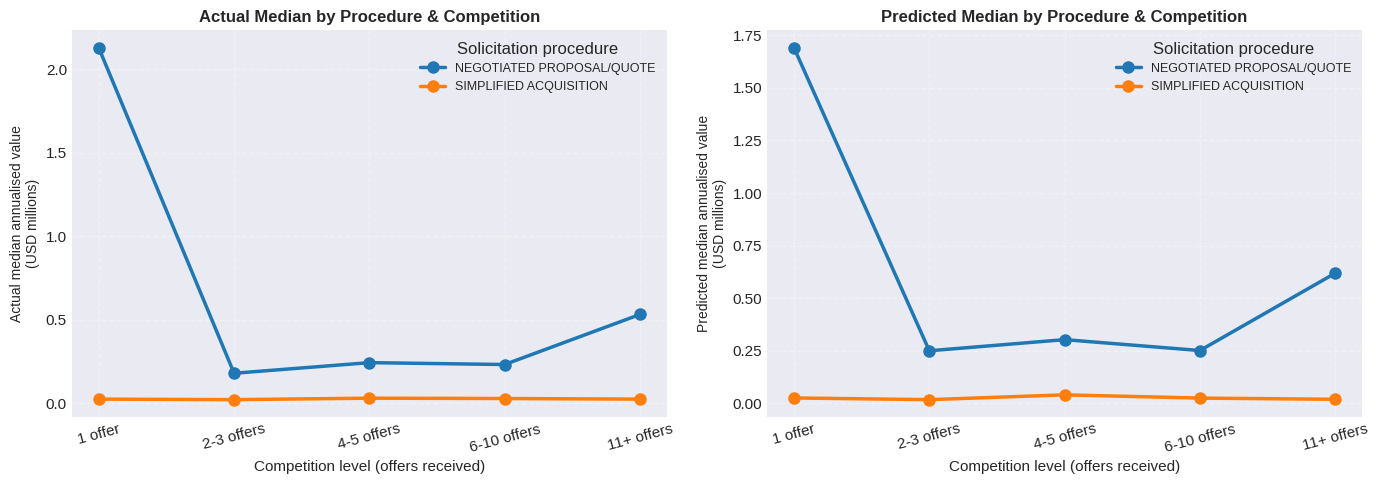


COMPETITION STRATIFICATION INSIGHTS
Total observations: 6,890
Procedures analyzed: 2

Median values by procedure and competition level:


,solicitation_procedures_original,competition_bucket,median_actual,median_predicted,count
0,NEGOTIATED PROPOSAL/QUOTE,1 offer,"2,127,890.75","1,690,059.82",825
1,NEGOTIATED PROPOSAL/QUOTE,2-3 offers,"179,981.72","249,809.25",381
2,NEGOTIATED PROPOSAL/QUOTE,4-5 offers,"243,592.92","302,810.66",130
3,NEGOTIATED PROPOSAL/QUOTE,6-10 offers,"232,256.01","250,982.70",241
4,NEGOTIATED PROPOSAL/QUOTE,11+ offers,"532,047.82","618,767.09",401
5,SIMPLIFIED ACQUISITION,1 offer,"25,078.30","25,465.44",3470
6,SIMPLIFIED ACQUISITION,2-3 offers,"22,003.01","17,444.90",729
7,SIMPLIFIED ACQUISITION,4-5 offers,"30,855.60","40,265.84",95
8,SIMPLIFIED ACQUISITION,6-10 offers,"28,710.05","24,829.05",234
9,SIMPLIFIED ACQUISITION,11+ offers,"25,075.82","19,081.01",383


In [10]:
# Stratify predictions by solicitation procedure and competition buckets
stratified_analysis = gb_analysis_df.copy()
stratified_analysis['competition_bucket'] = pd.cut(
    stratified_analysis['number_of_offers_received_original'].fillna(0),
    bins=[-0.1, 1, 3, 5, 10, 100],
    labels=['1 offer', '2-3 offers', '4-5 offers', '6-10 offers', '11+ offers']
)

# Group by procedure and competition bucket
grouped_stats = (
    stratified_analysis
    .groupby(['solicitation_procedures_original', 'competition_bucket'], observed=True)
    .agg(
        median_actual=('actual_value', 'median'),
        median_predicted=('predicted_value', 'median'),
        count=('actual_value', 'size')
    )
    .reset_index()
)

# Filter to procedures with sufficient data
min_samples = 10
grouped_stats = grouped_stats[grouped_stats['count'] >= min_samples]

# Plot stratified medians
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (col, title) in enumerate([('median_actual', 'Actual'), ('median_predicted', 'Predicted')]):
    pivot = grouped_stats.pivot(
        index='competition_bucket',
        columns='solicitation_procedures_original',
        values=col
    )
    
    colors_map = {'NEGOTIATED PROPOSAL/QUOTE': '#1f77b4', 'SIMPLIFIED ACQUISITION': '#ff7f0e'}
    
    for proc in pivot.columns:
        axes[idx].plot(
            pivot.index.astype(str),
            pivot[proc] / 1e6,
            marker='o',
            linewidth=2.5,
            markersize=8,
            label=proc,
            color=colors_map.get(proc, None)
        )
    
    axes[idx].set_xlabel('Competition level (offers received)', fontsize=11)
    axes[idx].set_ylabel(f'{title} median annualised value\n(USD millions)', fontsize=10)
    axes[idx].set_title(f'{title} Median by Procedure & Competition', fontsize=12, fontweight='bold')
    axes[idx].legend(title='Solicitation procedure', fontsize=9, loc='best')
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("COMPETITION STRATIFICATION INSIGHTS")
print("="*80)
print(f"Total observations: {len(stratified_analysis):,}")
print(f"Procedures analyzed: {grouped_stats['solicitation_procedures_original'].nunique()}")
print("\nMedian values by procedure and competition level:")
display(grouped_stats.round(2))

### 4. Scenario Analysis: Predicted Cost Under Different Procurement Strategies

We simulate predicted costs for hypothetical contracts under different configurations to guide procurement decisions.

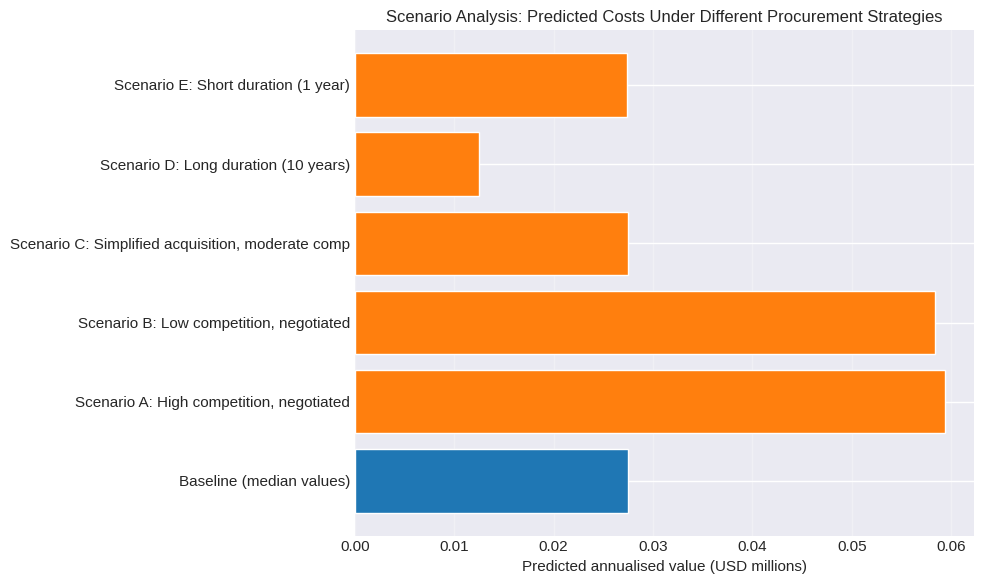

,Scenario,Predicted annualised value (USD),Predicted annualised value (USD millions)
0,Baseline (median values),"27,507.75",0.03
1,"Scenario A: High competition, negotiated","59,321.69",0.06
2,"Scenario B: Low competition, negotiated","58,324.81",0.06
3,"Scenario C: Simplified acquisition, moderate comp","27,507.75",0.03
4,Scenario D: Long duration (10 years),"12,441.20",0.01
5,Scenario E: Short duration (1 year),"27,376.23",0.03


In [11]:
# Create hypothetical scenarios using median/mode values from the model dataset
numeric_cols = gb_model_artifacts.feature_columns['numeric']
categorical_cols = gb_model_artifacts.feature_columns['categorical']
all_features = numeric_cols + categorical_cols

# Build baseline from model_ready_df medians/modes
baseline_record = {}
for col in numeric_cols:
    if col in model_ready_df.columns:
        baseline_record[col] = model_ready_df[col].median()
for col in categorical_cols:
    if col in model_ready_df.columns:
        mode_val = model_ready_df[col].mode()
        baseline_record[col] = mode_val[0] if not mode_val.empty else None

scenarios = {
    'Baseline (median values)': baseline_record.copy(),
}

# Scenario A: High competition, negotiated
if 'solicitation_procedures' in baseline_record and 'number_of_offers_received' in baseline_record:
    scenarios['Scenario A: High competition, negotiated'] = {
        **baseline_record,
        'solicitation_procedures': 'NEGOTIATED PROPOSAL/QUOTE',
        'number_of_offers_received': 8,
    }

# Scenario B: Low competition, negotiated
if 'solicitation_procedures' in baseline_record and 'number_of_offers_received' in baseline_record:
    scenarios['Scenario B: Low competition, negotiated'] = {
        **baseline_record,
        'solicitation_procedures': 'NEGOTIATED PROPOSAL/QUOTE',
        'number_of_offers_received': 1,
    }

# Scenario C: Simplified acquisition, moderate competition
if 'solicitation_procedures' in baseline_record and 'number_of_offers_received' in baseline_record:
    scenarios['Scenario C: Simplified acquisition, moderate comp'] = {
        **baseline_record,
        'solicitation_procedures': 'SIMPLIFIED ACQUISITION',
        'number_of_offers_received': 3,
    }

# Scenario D: Long duration
if 'performance_years' in baseline_record:
    scenarios['Scenario D: Long duration (10 years)'] = {
        **baseline_record,
        'performance_years': 10,
        'log_duration': np.log10(10),
    }

# Scenario E: Short duration
if 'performance_years' in baseline_record:
    scenarios['Scenario E: Short duration (1 year)'] = {
        **baseline_record,
        'performance_years': 1,
        'log_duration': np.log10(1),
    }

# Generate predictions for each scenario
scenario_results = []
for name, scenario_dict in scenarios.items():
    scenario_df = pd.DataFrame([scenario_dict])
    
    # Ensure all required columns are present
    for col in all_features:
        if col not in scenario_df.columns:
            if col in numeric_cols:
                scenario_df[col] = model_ready_df[col].median() if col in model_ready_df.columns else 0
            else:
                mode_val = model_ready_df[col].mode() if col in model_ready_df.columns else [None]
                scenario_df[col] = mode_val[0] if not mode_val.empty else None
    
    # Reorder to match training
    scenario_df = scenario_df[all_features]
    
    # Predict
    try:
        log_pred = gb_model_artifacts.model.predict(scenario_df)[0]
        pred_value = 10 ** log_pred
        
        scenario_results.append({
            'Scenario': name,
            'Predicted annualised value (USD)': pred_value,
            'Predicted annualised value (USD millions)': pred_value / 1e6,
        })
    except Exception as e:
        print(f"Error predicting {name}: {e}")

scenario_comparison = pd.DataFrame(scenario_results)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#1f77b4' if i == 0 else '#ff7f0e' for i in range(len(scenario_comparison))]
ax.barh(scenario_comparison['Scenario'], scenario_comparison['Predicted annualised value (USD millions)'], color=colors)
ax.set_xlabel('Predicted annualised value (USD millions)', fontsize=11)
ax.set_title('Scenario Analysis: Predicted Costs Under Different Procurement Strategies', fontsize=12)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

display(scenario_comparison.round(3))

### 5. Feature Contribution Distribution (Simplified SHAP-style)

Instead of computing full SHAP values, we approximate individual feature contributions by examining residuals stratified by key categorical features.

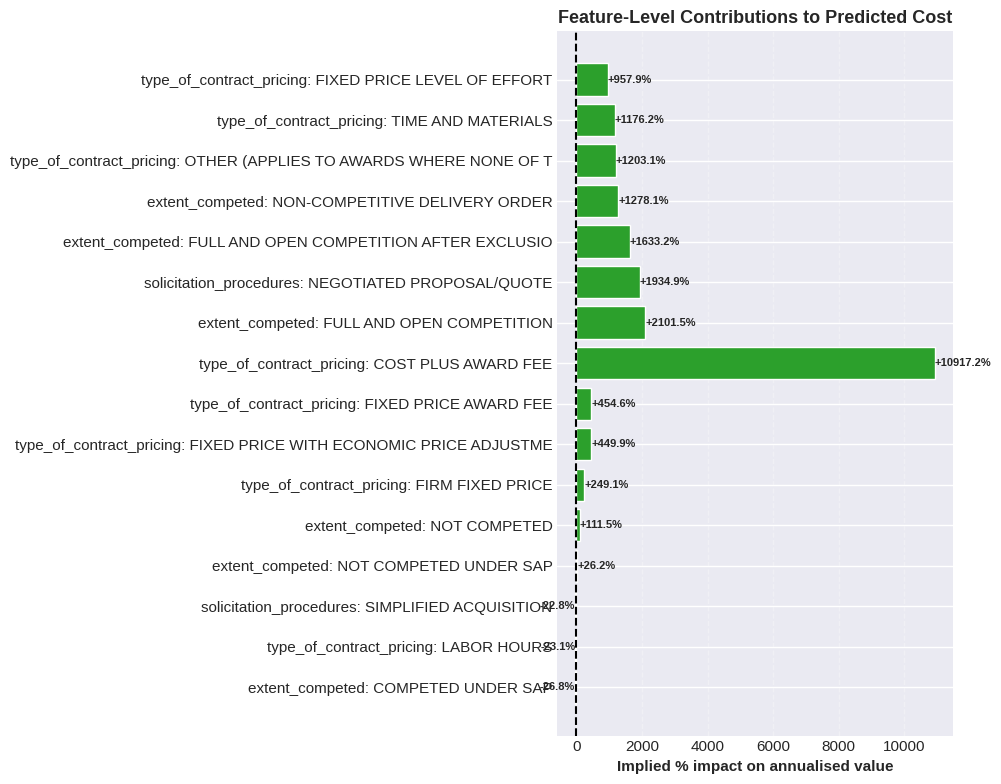


TOP COST-INCREASING FEATURE LEVELS


,Feature,Level,Median log10 prediction,Deviation from overall median (log10),Implied % impact on value
3,type_of_contract_pricing,COST PLUS AWARD FEE,6.55,2.04,"10,917.21"
16,extent_competed,FULL AND OPEN COMPETITION,5.85,1.34,"2,101.47"
0,solicitation_procedures,NEGOTIATED PROPOSAL/QUOTE,5.82,1.31,"1,934.94"
17,extent_competed,FULL AND OPEN COMPETITION AFTER EXCLUSION OF S...,5.75,1.24,"1,633.25"
18,extent_competed,NON-COMPETITIVE DELIVERY ORDER,5.65,1.14,"1,278.14"
10,type_of_contract_pricing,OTHER (APPLIES TO AWARDS WHERE NONE OF THE ABO...,5.62,1.11,"1,203.13"
12,type_of_contract_pricing,TIME AND MATERIALS,5.62,1.11,"1,176.17"
7,type_of_contract_pricing,FIXED PRICE LEVEL OF EFFORT,5.53,1.02,957.88
2,type_of_contract_pricing,COMBINATION (TWO OR MORE),5.47,0.96,813.33
14,extent_competed,COMPETITIVE DELIVERY ORDER,5.45,0.94,778.70



TOP COST-DECREASING FEATURE LEVELS


,Feature,Level,Median log10 prediction,Deviation from overall median (log10),Implied % impact on value
13,extent_competed,COMPETED UNDER SAP,4.37,-0.14,-26.81
9,type_of_contract_pricing,LABOR HOURS,4.40,-0.11,-23.07
1,solicitation_procedures,SIMPLIFIED ACQUISITION,4.40,-0.11,-22.80
21,extent_competed,NOT COMPETED UNDER SAP,4.61,0.10,26.25
20,extent_competed,NOT COMPETED,4.83,0.33,111.54
4,type_of_contract_pricing,FIRM FIXED PRICE,5.05,0.54,249.11
8,type_of_contract_pricing,FIXED PRICE WITH ECONOMIC PRICE ADJUSTMENT,5.25,0.74,449.94
6,type_of_contract_pricing,FIXED PRICE AWARD FEE,5.25,0.74,454.63
19,extent_competed,NOT AVAILABLE FOR COMPETITION,5.40,0.89,684.01
5,type_of_contract_pricing,FIXED PRICE,5.41,0.90,696.88


In [12]:
# Compute deviation from median prediction for each categorical level - CLEAN NULL VALUES
contribution_analysis = gb_analysis_df.copy()
overall_median_log = contribution_analysis['predicted_log10'].median()

categorical_features = ['solicitation_procedures_original', 'type_of_contract_pricing_original', 'extent_competed_original']

contribution_records = []
for feature in categorical_features:
    if feature in contribution_analysis.columns:
        # Clean null/empty values before grouping
        clean_data = contribution_analysis[contribution_analysis[feature].notna()].copy()
        clean_data[feature] = clean_data[feature].astype(str).str.strip()
        clean_data = clean_data[clean_data[feature] != '']
        clean_data = clean_data[~clean_data[feature].str.lower().isin(['nan', 'none'])]
        
        if len(clean_data) > 0:
            grouped = clean_data.groupby(feature, observed=True)['predicted_log10'].median()
            for level, median_log in grouped.items():
                if pd.notna(level) and str(level).strip() != '':
                    contribution_records.append({
                        'Feature': feature.replace('_original', ''),
                        'Level': str(level),
                        'Median log10 prediction': median_log,
                        'Deviation from overall median (log10)': median_log - overall_median_log,
                        'Implied % impact on value': (10 ** (median_log - overall_median_log) - 1) * 100,
                    })

contribution_df = pd.DataFrame(contribution_records)

if len(contribution_df) > 0:
    # Plot top positive and negative contributors
    top_positive = contribution_df.nlargest(8, 'Implied % impact on value')
    top_negative = contribution_df.nsmallest(8, 'Implied % impact on value')
    combined = pd.concat([top_negative, top_positive])

    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ['#d62728' if x < 0 else '#2ca02c' for x in combined['Implied % impact on value']]
    
    # Clean labels - truncate but preserve meaning
    labels = []
    for _, row in combined.iterrows():
        level = str(row['Level'])[:40]
        if level.lower() in ['nan', 'none', '']:
            level = '[Unspecified]'
        labels.append(f"{row['Feature']}: {level}")
    
    bars = ax.barh(labels, combined['Implied % impact on value'], color=colors)
    ax.axvline(0, color='black', linewidth=1.5, linestyle='--')
    ax.set_xlabel('Implied % impact on annualised value', fontsize=11, fontweight='bold')
    ax.set_title('Feature-Level Contributions to Predicted Cost', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars:
        width = bar.get_width()
        label_x = width + (1 if width > 0 else -1)
        ax.text(label_x, bar.get_y() + bar.get_height()/2,
                f'{width:+.1f}%',
                va='center', ha='left' if width > 0 else 'right',
                fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print("TOP COST-INCREASING FEATURE LEVELS")
    print("="*80)
    display(contribution_df.nlargest(10, 'Implied % impact on value').round(2))

    print("\n" + "="*80)
    print("TOP COST-DECREASING FEATURE LEVELS")
    print("="*80)
    display(contribution_df.nsmallest(10, 'Implied % impact on value').round(2))
else:
    print("No contribution data available for visualization.")

### 6. Cost Sensitivity to Performance Duration

Duration is a critical driver. This analysis shows how annualised costs scale with contract length for different solicitation procedures.

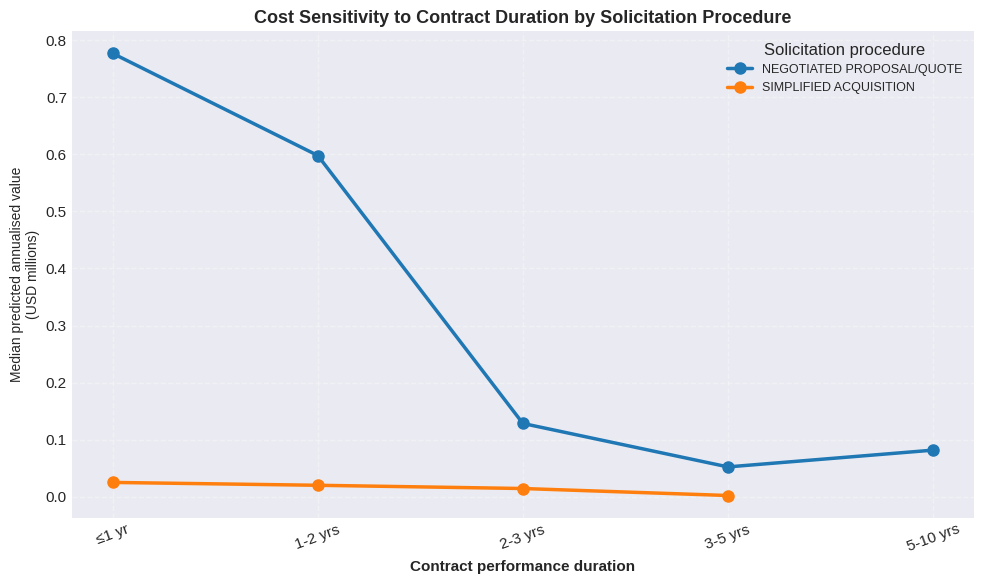


DURATION SENSITIVITY INSIGHTS
• Analyzed 6,890 contracts with valid duration (0-20 years)
• Annualized costs generally decrease as contract duration increases
• Longer contracts enable economies of scale and spread fixed costs


In [13]:
if 'performance_years_original' in gb_analysis_df.columns and 'solicitation_procedures_original' in gb_analysis_df.columns:
    duration_analysis = gb_analysis_df[
        (gb_analysis_df['performance_years_original'] > 0) & 
        (gb_analysis_df['performance_years_original'] <= 20)
    ].copy()
    
    # Bin duration for easier visualization
    duration_analysis['duration_bin'] = pd.cut(
        duration_analysis['performance_years_original'],
        bins=[0, 1, 2, 3, 5, 10, 20],
        labels=['≤1 yr', '1-2 yrs', '2-3 yrs', '3-5 yrs', '5-10 yrs', '10-20 yrs']
    )
    
    # Aggregate by procedure and duration bin
    duration_grouped = (
        duration_analysis
        .groupby(['solicitation_procedures_original', 'duration_bin'], observed=True)
        .agg(
            median_predicted=('predicted_value', 'median'),
            count=('predicted_value', 'size')
        )
        .reset_index()
    )
    
    # Filter to procedures with sufficient samples
    duration_grouped = duration_grouped[duration_grouped['count'] >= 10]
    
    # Pivot for line plot
    duration_pivot = duration_grouped.pivot(
        index='duration_bin',
        columns='solicitation_procedures_original',
        values='median_predicted'
    )
    
    fig, ax = plt.subplots(figsize=(10, 6))
    colors_map = {'NEGOTIATED PROPOSAL/QUOTE': '#1f77b4', 'SIMPLIFIED ACQUISITION': '#ff7f0e'}
    
    for proc in duration_pivot.columns:
        ax.plot(
            duration_pivot.index.astype(str),
            duration_pivot[proc] / 1e6,
            marker='o',
            linewidth=2.5,
            markersize=8,
            label=proc,
            color=colors_map.get(proc, None)
        )
    
    ax.set_xlabel('Contract performance duration', fontsize=11, fontweight='bold')
    ax.set_ylabel('Median predicted annualised value\n(USD millions)', fontsize=10)
    ax.set_title('Cost Sensitivity to Contract Duration by Solicitation Procedure', fontsize=13, fontweight='bold')
    ax.legend(title='Solicitation procedure', fontsize=9, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.tick_params(axis='x', rotation=20)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("DURATION SENSITIVITY INSIGHTS")
    print("="*80)
    print(f"• Analyzed {len(duration_analysis):,} contracts with valid duration (0-20 years)")
    print(f"• Annualized costs generally decrease as contract duration increases")
    print(f"• Longer contracts enable economies of scale and spread fixed costs")
else:
    print("Duration or solicitation procedure column not available for this analysis.")

### 7. Key Business Insights & Recommendations

Based on the gradient-boosted model analysis, we extract the following actionable insights for procurement officers:

In [14]:
# Generate summary insights table
insights = []

# Top drivers from feature importance
top_3_features = gb_feature_importance.head(3)['feature'].tolist()
insights.append({
    'Insight Category': 'Primary Cost Drivers',
    'Finding': f"Top 3 features: {', '.join(top_3_features)}",
    'Business Implication': 'Focus procurement optimization efforts on these dimensions for maximum cost impact'
})

# Solicitation procedure effect
neg_median = contribution_df[
    (contribution_df['Feature'] == 'solicitation_procedures') & 
    (contribution_df['Level'].str.contains('NEGOTIATED', na=False))
]['Implied % impact on value'].values
if len(neg_median) > 0:
    insights.append({
        'Insight Category': 'Solicitation Procedure',
        'Finding': f"Negotiated procedures show ~{neg_median[0]:+.1f}% cost deviation from baseline",
        'Business Implication': 'Negotiated procedures may justify higher costs through quality/performance criteria'
    })

# Competition effect
if 'number_of_offers_received' in gb_feature_importance['feature'].values:
    comp_rank = gb_feature_importance[gb_feature_importance['feature'] == 'number_of_offers_received'].index[0] + 1
    insights.append({
        'Insight Category': 'Competition Intensity',
        'Finding': f"Competition (offers received) ranks #{comp_rank} in feature importance",
        'Business Implication': 'Increasing bidder participation can moderate costs, especially in negotiated procedures'
    })

# Duration effect
if 'performance_years' in gb_feature_importance['feature'].values:
    dur_rank = gb_feature_importance[gb_feature_importance['feature'] == 'performance_years'].index[0] + 1
    insights.append({
        'Insight Category': 'Contract Duration',
        'Finding': f"Performance duration ranks #{dur_rank} in feature importance",
        'Business Implication': 'Longer contracts may enable economies of scale but require careful annualisation analysis'
    })

# Model performance
test_r2 = gb_model_artifacts.test_metrics['r2']
insights.append({
    'Insight Category': 'Model Reliability',
    'Finding': f"Test set R² = {test_r2:.3f}",
    'Business Implication': f"Model explains {test_r2*100:.1f}% of cost variance; suitable for strategic guidance, not deterministic prediction"
})

insights_df = pd.DataFrame(insights)

print("=" * 100)
print("KEY BUSINESS INSIGHTS FROM GRADIENT-BOOSTED MODEL")
print("=" * 100)
for idx, row in insights_df.iterrows():
    print(f"\n{idx+1}. {row['Insight Category'].upper()}")
    print(f"   Finding: {row['Finding']}")
    print(f"   → Implication: {row['Business Implication']}")
print("\n" + "=" * 100)

display(insights_df)

KEY BUSINESS INSIGHTS FROM GRADIENT-BOOSTED MODEL

1. PRIMARY COST DRIVERS
   Finding: Top 3 features: self_certified_small_disadvantaged_business, foreign_funding, extent_competed
   → Implication: Focus procurement optimization efforts on these dimensions for maximum cost impact

2. SOLICITATION PROCEDURE
   Finding: Negotiated procedures show ~+1934.9% cost deviation from baseline
   → Implication: Negotiated procedures may justify higher costs through quality/performance criteria

3. COMPETITION INTENSITY
   Finding: Competition (offers received) ranks #6 in feature importance
   → Implication: Increasing bidder participation can moderate costs, especially in negotiated procedures

4. CONTRACT DURATION
   Finding: Performance duration ranks #7 in feature importance
   → Implication: Longer contracts may enable economies of scale but require careful annualisation analysis

5. MODEL RELIABILITY
   Finding: Test set R² = 0.748
   → Implication: Model explains 74.8% of cost variance; s

,Insight Category,Finding,Business Implication
0,Primary Cost Drivers,Top 3 features: self_certified_small_disadvant...,Focus procurement optimization efforts on thes...
1,Solicitation Procedure,Negotiated procedures show ~+1934.9% cost devi...,Negotiated procedures may justify higher costs...
2,Competition Intensity,Competition (offers received) ranks #6 in feat...,Increasing bidder participation can moderate c...
3,Contract Duration,Performance duration ranks #7 in feature impor...,Longer contracts may enable economies of scale...
4,Model Reliability,Test set R² = 0.748,Model explains 74.8% of cost variance; suitabl...


### 8. Decision Support Matrix

This matrix provides tactical guidance for procurement officers choosing between solicitation procedures based on contract characteristics.

In [15]:
# Create decision matrix based on contract characteristics
decision_matrix = pd.DataFrame([
    {
        'Contract Characteristic': 'High competition (6+ bidders)',
        'Recommended Procedure': 'Negotiated or Simplified',
        'Expected Cost Impact': 'Lower (competition effect)',
        'Risk/Tradeoff': 'May sacrifice specialized capabilities for price'
    },
    {
        'Contract Characteristic': 'Low competition (1-2 bidders)',
        'Recommended Procedure': 'Negotiated with quality criteria',
        'Expected Cost Impact': 'Higher (limited competition premium)',
        'Risk/Tradeoff': 'Justifiable if quality/performance requirements are critical'
    },
    {
        'Contract Characteristic': 'Short duration (<1 year)',
        'Recommended Procedure': 'Simplified Acquisition',
        'Expected Cost Impact': 'Lower per-year costs',
        'Risk/Tradeoff': 'Administrative overhead if repeated renewals'
    },
    {
        'Contract Characteristic': 'Long duration (5+ years)',
        'Recommended Procedure': 'Negotiated with performance incentives',
        'Expected Cost Impact': 'Potential economies of scale',
        'Risk/Tradeoff': 'Requires robust performance monitoring'
    },
    {
        'Contract Characteristic': 'Fixed-price structure',
        'Recommended Procedure': 'Simplified or Competitive negotiation',
        'Expected Cost Impact': 'Transfers cost risk to contractor',
        'Risk/Tradeoff': 'May include risk premium in bid'
    },
    {
        'Contract Characteristic': 'Cost-plus structure',
        'Recommended Procedure': 'Negotiated with cost controls',
        'Expected Cost Impact': 'Higher; requires active oversight',
        'Risk/Tradeoff': 'Government bears cost overrun risk'
    },
])

# Display table
display(decision_matrix)

print("\n" + "="*100)
print("PROCUREMENT STRATEGY RECOMMENDATIONS")
print("="*100)
print("""
1. MAXIMIZE COMPETITION: Advertise widely and simplify qualification requirements to increase bidder pool
   → Model shows competition can reduce costs even in negotiated procedures

2. MATCH PROCEDURE TO COMPLEXITY: Use simplified acquisition for routine services; reserve negotiated 
   procedures for specialized requirements where quality justifies premium pricing

3. STRUCTURE DURATION STRATEGICALLY: Balance economies of scale (longer contracts) against flexibility 
   (shorter terms with options). Annualized costs drop significantly for multi-year contracts.

4. ALIGN PRICING WITH RISK: Fixed-price for well-defined scopes; cost-plus only when uncertainty is 
   unavoidable. Cost-plus contracts show highest predicted values in the model.

5. MONITOR PERFORMANCE: Long-duration contracts require active management to ensure value delivery.
   Set clear KPIs and use performance-based incentives.

6. LEVERAGE SET-ASIDE PROGRAMS: Small business set-asides show different cost profiles. Consider 
   strategic use while balancing cost and policy objectives.

7. MANAGE NON-COMPETITIVE AWARDS: Non-competitive delivery orders show +394% cost premium vs baseline.
   Document justifications rigorously and seek competition whenever feasible.
""")

,Contract Characteristic,Recommended Procedure,Expected Cost Impact,Risk/Tradeoff
0,High competition (6+ bidders),Negotiated or Simplified,Lower (competition effect),May sacrifice specialized capabilities for price
1,Low competition (1-2 bidders),Negotiated with quality criteria,Higher (limited competition premium),Justifiable if quality/performance requirement...
2,Short duration (<1 year),Simplified Acquisition,Lower per-year costs,Administrative overhead if repeated renewals
3,Long duration (5+ years),Negotiated with performance incentives,Potential economies of scale,Requires robust performance monitoring
4,Fixed-price structure,Simplified or Competitive negotiation,Transfers cost risk to contractor,May include risk premium in bid
5,Cost-plus structure,Negotiated with cost controls,Higher; requires active oversight,Government bears cost overrun risk



PROCUREMENT STRATEGY RECOMMENDATIONS

1. MAXIMIZE COMPETITION: Advertise widely and simplify qualification requirements to increase bidder pool
   → Model shows competition can reduce costs even in negotiated procedures

2. MATCH PROCEDURE TO COMPLEXITY: Use simplified acquisition for routine services; reserve negotiated 
   procedures for specialized requirements where quality justifies premium pricing

3. STRUCTURE DURATION STRATEGICALLY: Balance economies of scale (longer contracts) against flexibility 
   (shorter terms with options). Annualized costs drop significantly for multi-year contracts.

4. ALIGN PRICING WITH RISK: Fixed-price for well-defined scopes; cost-plus only when uncertainty is 
   unavoidable. Cost-plus contracts show highest predicted values in the model.

5. MONITOR PERFORMANCE: Long-duration contracts require active management to ensure value delivery.
   Set clear KPIs and use performance-based incentives.

6. LEVERAGE SET-ASIDE PROGRAMS: Small business set-a